# Part II - Prosper Loan Data Analysis
## by Sharlet Teresa Shaji

## Investigation Overview

The analysis of the Prosper Loan dataset aims to identify factors that influence loan outcomes, with a focus on loan status, borrower APR, and default rates. By examining borrower demographics, credit scores, and loan specifics, the study seeks to uncover patterns and relationships that can enhance risk assessment and loan management strategies.


## Dataset Overview and Executive Summary

The Prosper Loan dataset includes 113,937 loans with various attributes. The analysis reveals that while over 50% of loans are completed, more than 16% are charged off or defaulted, raising concerns. CreditGrade distribution is skewed towards higher grades, and ProsperRating displays a Gaussian distribution. Employment status analysis shows higher default rates for borrowers with 'Not available', 'Retired', and 'Full-time' statuses. Correlation analysis indicates that CreditGrade negatively correlates with AmountDelinquent, PublicRecordsLast10Years, and BorrowerAPR, suggesting better credit grades lead to lower risks and APRs. Borrower APR is higher for charged off and defaulted loans, implying that reducing borrower rates might lower defaults. Visual tools like bar plots, heatmaps, and KDE plots provide valuable insights for improving loan performance.

In [4]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [6]:
# load in the dataset into a pandas dataframe
loans = pd.read_csv('prosperLoanData.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'prosperLoanData.csv'

In [ ]:
counts=loans['LoanStatus'].value_counts()

## Univariate Exploration


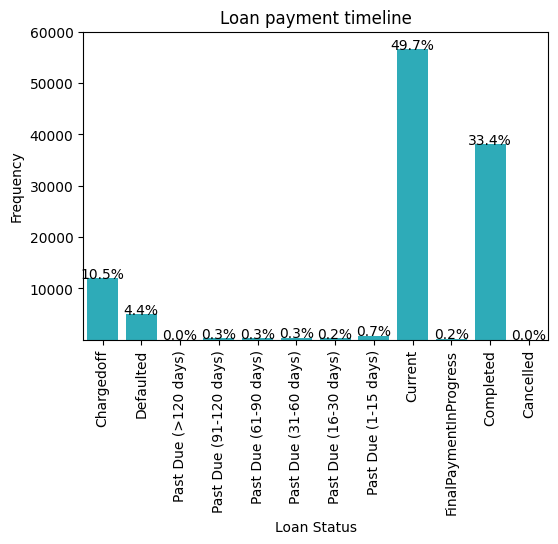

In [5]:
import seaborn as sb
# Let's reorder this categorical data from worst to best, based on level of lender distaste. 
# A cancelled loan doesn't necessarily impact the lender negatively, 
# other than for the fact that the lender has to find another borrower. 
# So we place Cancelled last, to represent a 'neutral' status.
fig = plt.figure(figsize=(6, 4))

ls_order = ['Chargedoff', 'Defaulted', 'Past Due (>120 days)', 'Past Due (91-120 days)',
            'Past Due (61-90 days)', 'Past Due (31-60 days)', 'Past Due (16-30 days)', 
            'Past Due (1-15 days)', 'Current', 'FinalPaymentInProgress', 'Completed', 'Cancelled']

# We can now view this on the bar chart

default_color = sb.color_palette()[9]

ax = sb.countplot(data = loans, x = 'LoanStatus', color = default_color, order = ls_order)
plt.xticks(rotation = 90)

for i in range(len(ls_order)):
    count = counts[ls_order[i]]
    #print(ls_order[i], ': ', count)
    display_val = '{:.1f}%'.format(100 * count / sum(counts))
    plt.text(i, count + 1, display_val, va = 'baseline', ha = 'center')

plt.title('Loan payment timeline')
plt.yticks([10000, 20000, 30000, 40000, 50000, 60000])
plt.xlabel('Loan Status')
plt.ylabel('Frequency')

fig.savefig('output1.png', bbox_inches='tight');

We see that more than 50% of the loans are completed which is encouraging, however its concerning that more than 16% of the total loan amount are considered as charged off or as defaulted. 

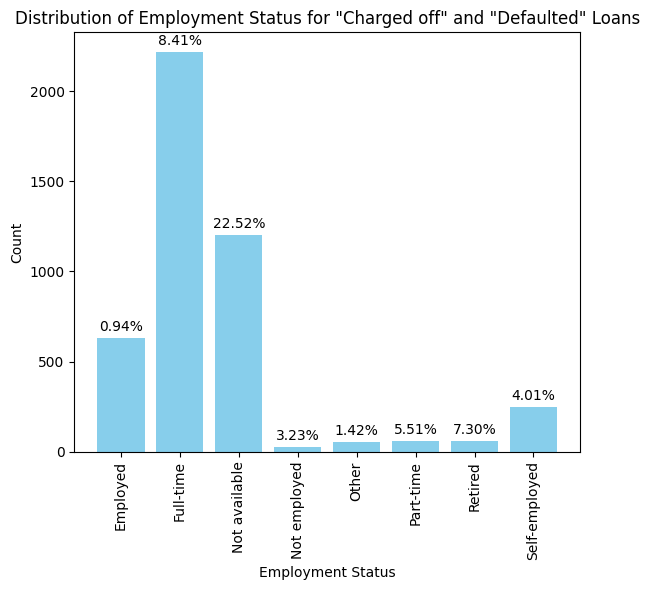

In [6]:
# Filter the DataFrame for 'Charged off' and 'Defaulted' loan statuses
filtered_loans = loans[(loans['LoanStatus'] == 'Charged off') | (loans['LoanStatus'] == 'Defaulted')]

# Calculate total counts for each EmploymentStatus in the entire DataFrame
total_counts = loans['EmploymentStatus'].value_counts()

# Calculate counts for the filtered DataFrame for 'Charged off' and 'Defaulted'
filtered_counts = filtered_loans['EmploymentStatus'].value_counts()

# Creating a DataFrame from counts
employment_data = pd.DataFrame({
    'TotalCount': total_counts,
    'FilteredCount': filtered_counts
}).fillna(0)  # Fill missing values with 0

# Calculate the percentage
employment_data['Percentage'] = (employment_data['FilteredCount'] / employment_data['TotalCount'] * 100).round(2)

# Plotting
plt.figure(figsize=(6,6))
bars = plt.bar(employment_data.index, employment_data['FilteredCount'], color='skyblue')

# Use bar_label to add labels to the bars
plt.bar_label(bars, labels=[f'{p:.2f}%' for p in employment_data['Percentage']], padding=3)

plt.title('Distribution of Employment Status for "Charged off" and "Defaulted" Loans')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
fig.savefig('outputt1.png', bbox_inches='tight');

We see that 22.52% of the NA Employment status has charged off or defaulted loan status. Among the retired employees and Full time employees contributes more the charged distribution checking the statistics of the distribution.

Now we try to analyse the credit scores of the listings with loan status as charged off or defaulted.

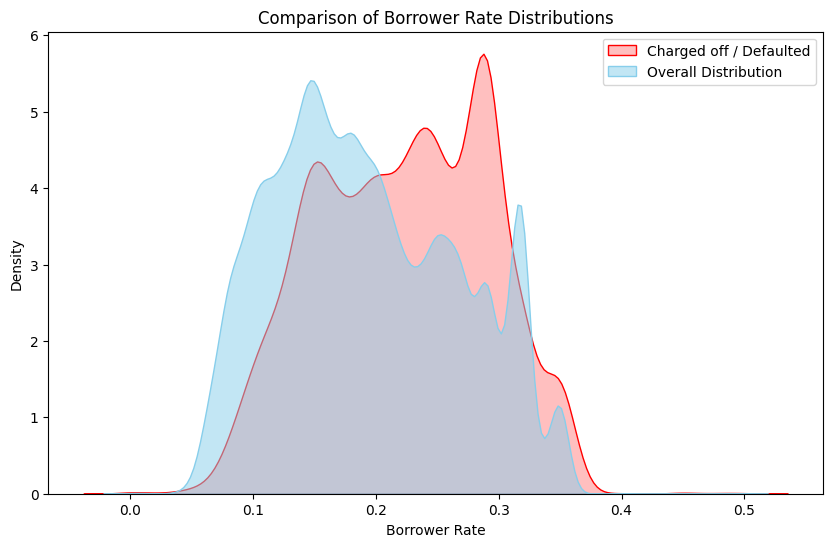

In [7]:
# Filter the DataFrame for 'Charged off' and 'Defaulted' loan statuses
filtered_loans = loans[(loans['LoanStatus'] == 'Charged off') | (loans['LoanStatus'] == 'Defaulted')]

# Plotting the KDE of BorrowerRate for these filtered loan statuses
plt.figure(figsize=(10, 6))

# KDE plot for the filtered data
sns.kdeplot(data=filtered_loans, x='BorrowerRate', fill=True, label='Charged off / Defaulted', color='red')

# KDE plot for the entire dataset
sns.kdeplot(data=loans, x='BorrowerRate', fill=True, label='Overall Distribution', color='skyblue', alpha=0.5)

plt.title('Comparison of Borrower Rate Distributions')
plt.xlabel('Borrower Rate')
plt.ylabel('Density')
plt.legend()  # Add a legend to distinguish the plots
plt.show()
fig.savefig('outputt2.png', bbox_inches='tight');

## Bivariate Exploration

### Lower Borrower Rate Reduce Loan Defaults

From the kde plot we see that the Borrower rate is higher for charged offs and defaulted loans when compared to the overall loan status. Hence, introducing a margin for the borrower rates could lead to lower number of loans labelled as "Charged Offs" and "Defaulted".

### Expected Correlations

We try to the correlation between a few variables, our expectations looks like these:

CreditGrade: Negatively correlated with AmountDelinquent, PublicRecordsLast10Years, and BorrowerAPR.
AmountDelinquent: Positively correlated with PublicRecordsLast10Years and BorrowerAPR.
PublicRecordsLast10Years: Positively correlated with BorrowerAPR

In [8]:
#Changing Credit score value from the alphabetical to numerical for further analysis
credit_grade= {
    'HR': 1,
    'E': 2,
    'D': 3,
    'C': 4,
    'B': 5,
    'A': 6,
    'AA': 7,
    'NC': None  # Assuming 'NC' should be treated as NaN
}

# Apply the mapping to the 'CreditGrade' column
loans['CreditGrade'] = loans['CreditGrade'].map(credit_grade)
loans.CreditGrade.unique()

array([ 4., nan,  1.,  7.,  3.,  5.,  2.,  6.])

In [9]:
numeric_vars = ['CreditGrade', 'AmountDelinquent', 'PublicRecordsLast10Years', 'BorrowerAPR']
categoric_vars = ['EmploymentStatus', 'ListingCategory', 'LoanStatus', 'ProsperRating (Alpha)']

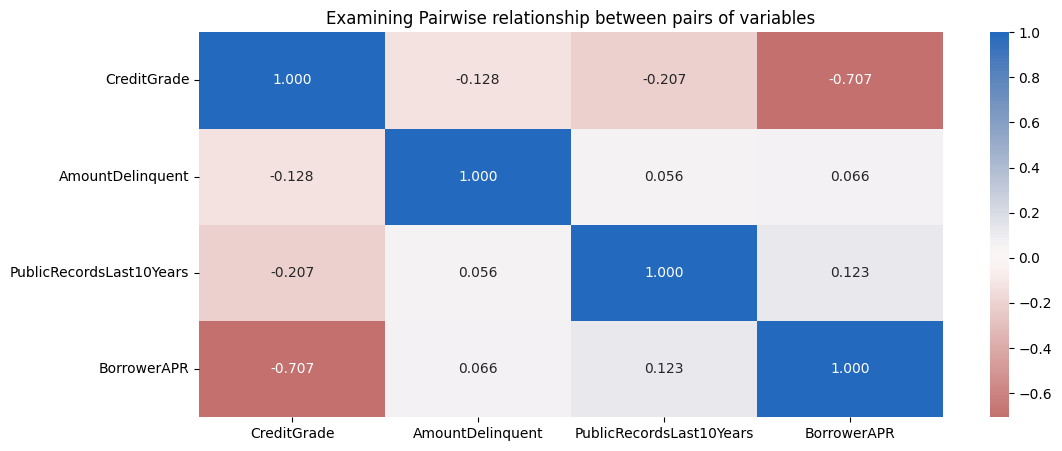

In [10]:
plt.figure(figsize = [12, 5])
sb.heatmap(loans[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.title('Examining Pairwise relationship between pairs of variables');
plt.show()
fig.savefig('output11.png', bbox_inches='tight');

#### Matches Expectation:

CreditGrade and AmountDelinquent (weak negative correlation) <br>
CreditGrade and PublicRecordsLast10Years (moderate negative correlation) <br>
CreditGrade and BorrowerAPR (strong negative correlation) <br>
PublicRecordsLast10Years and BorrowerAPR (weak positive correlation) <br>

#### Lost a Mark:

AmountDelinquent and PublicRecordsLast10Years (very weak positive correlation) <br>
AmountDelinquent and BorrowerAPR (very weak positive correlation) <br>

#### Suggestion:
Next time we could try to represent the plot as a gradient by prudent selection of color pallette.

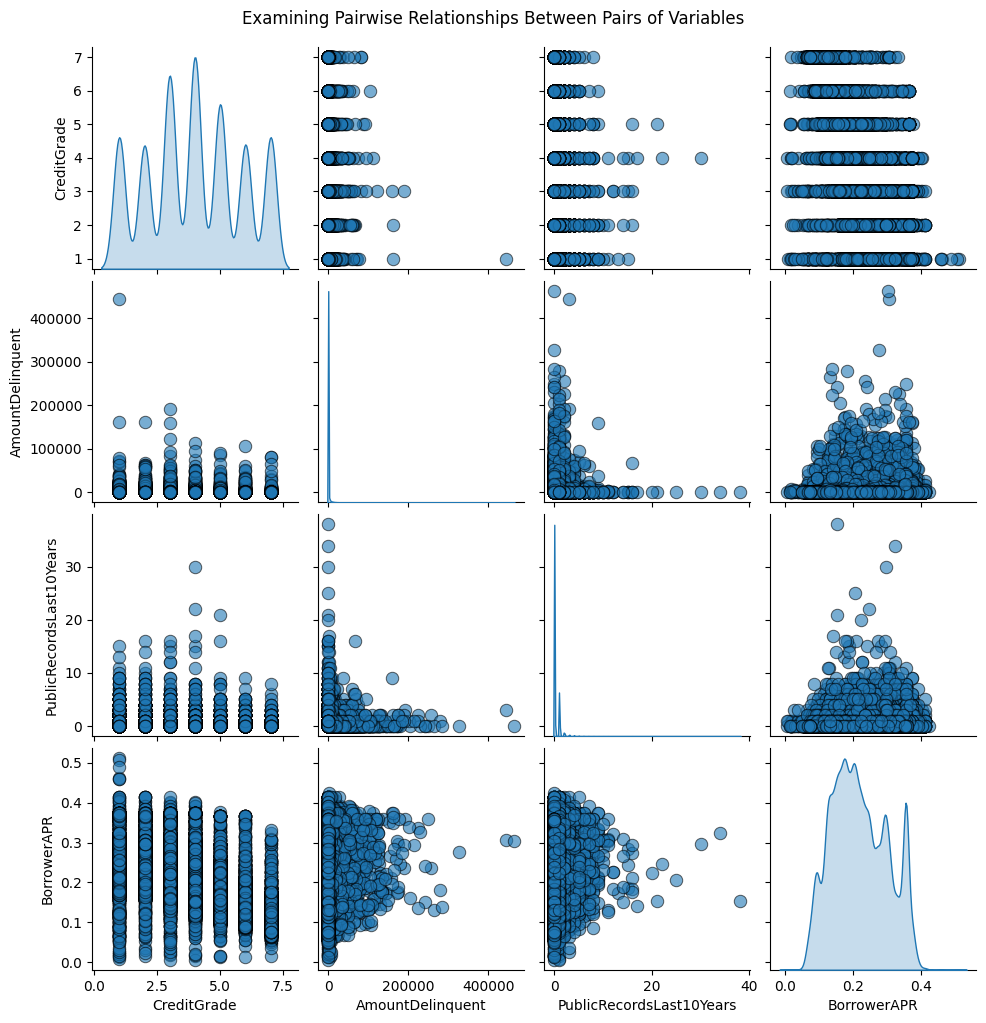

In [11]:
# Creating the pairplot with KDEs on the diagonal and scatter plots on the off-diagonal
g = sns.pairplot(loans[numeric_vars], diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

# Adjusting the title and layout
g.fig.suptitle('Examining Pairwise Relationships Between Pairs of Variables', y=1.02)

# Saving the figure
g.savefig('output11.png', bbox_inches='tight')

# Showing the plot
plt.show()

We see best type of loans given to full-time employed customers but it is also quite likely to be chargedoff. The below multivariate shows several indicators:

It seems that there is no correlation between Cancelled loans, PastDue and Borrower APR.

We additionally need to check if all our variables are ordinal or not.

In [53]:
loans = loans.rename(columns={'ListingCategory (numeric)': 'ListingCategory'})

<Figure size 1000x1000 with 0 Axes>

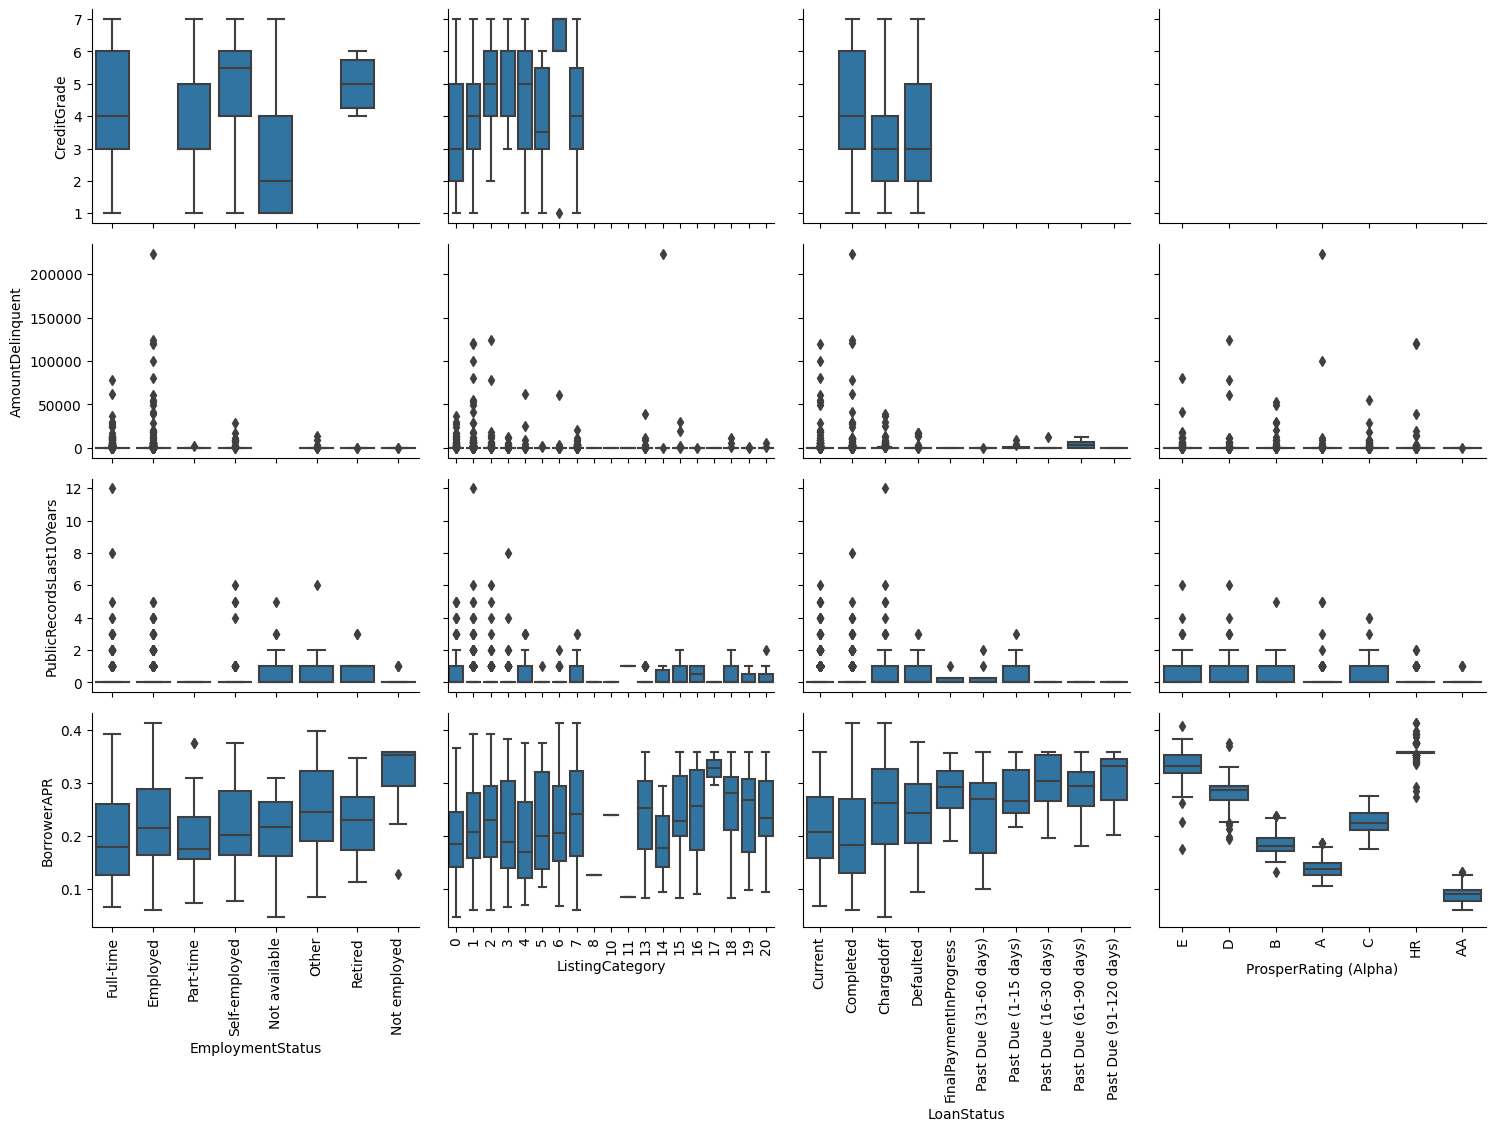

In [54]:
samples = np.random.choice(loans.shape[0], 2000, replace = False)
df_samp = loans.reindex(index = samples)

def boxgrid(x, y, **kwargs):
#Quick hack for creating box plots with seaborn's PairGrid
    default_color = sb.color_palette()[0]
    sb.boxplot(x=x, y=y, color = default_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = df_samp, y_vars = numeric_vars , x_vars = categoric_vars,
             aspect = 1.5)
g.map(boxgrid)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

# using padding
#fig.tight_layout(pad=5.0)

plt.show();

fig.savefig('output12.png', bbox_inches='tight')

In [ ]:
!python -m nbconvert --to html DataExplanation.ipynb